In [1]:
import tensorflow as tf
import cv2
import glob
import random
import IPython.display as display

In [2]:
train_img_dir = 'data/train_images/'
train_img_suffix = '.jpg'

In [3]:
all_image_paths = list(glob.glob(train_img_dir + '*' + train_img_suffix))

In [4]:
random.shuffle(all_image_paths)

In [5]:
image_count = len(all_image_paths)
image_count

12568

image id = 4bf995227


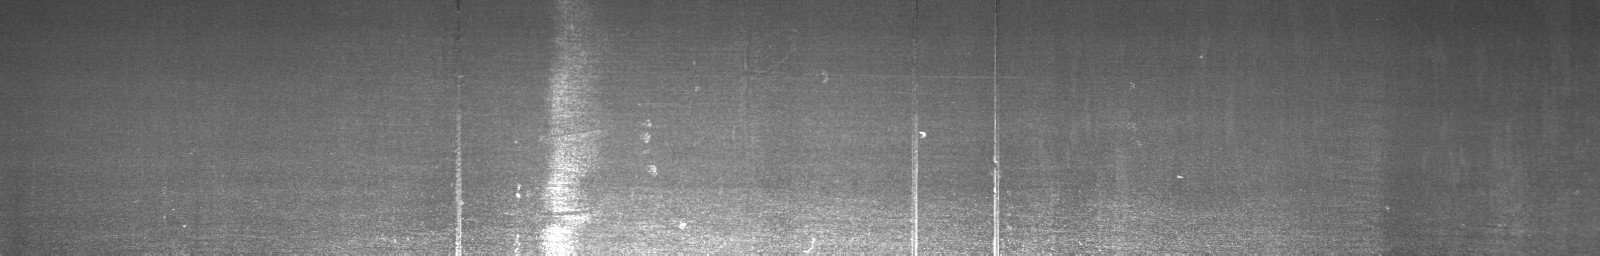


image id = 72bebf035


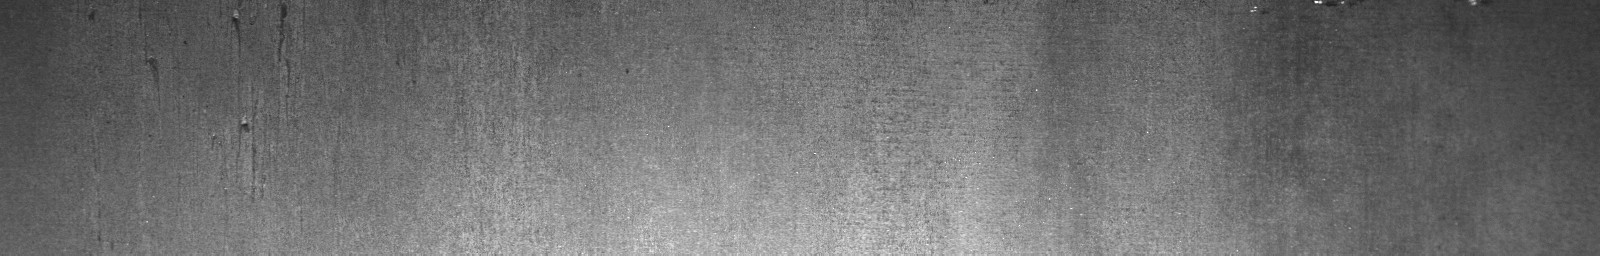


image id = 4ff2ec64b


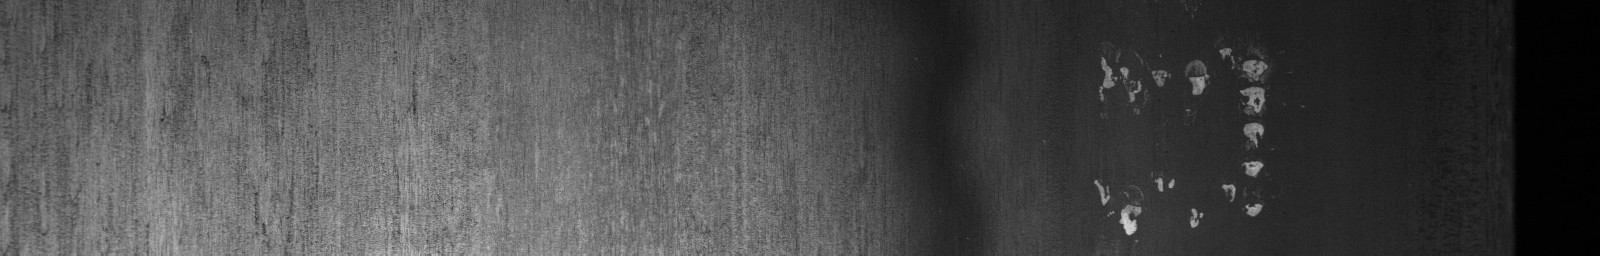

In [6]:
for n in range(3):
    image_path = random.choice(all_image_paths)
    image_name = image_path.strip(train_img_dir).strip(train_img_suffix)
    print("image id = {}".format(image_name))
    display.display(display.Image(image_path))
    print()